In [1]:
import pandas as pd
from scipy import stats
from scipy.spatial import distance
# from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error, mean_squared_error

from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              AdaBoostRegressor, ExtraTreesRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import pickle
# Different Scalers for transcripts and methylations
TPMscaler = StandardScaler()
Methscaler = StandardScaler()

In [2]:
TrainMeth = pd.read_pickle('../GenesBasedPrediction/TrainMeth.pkl')
TrainTpm = pd.read_pickle('../GenesBasedPrediction/TrainTpm.pkl')

In [3]:
CsvDf = pd.read_csv('../GenesBasedPrediction/All.CPGs.Genes.Results.csv',low_memory=False)
CsvDf = CsvDf.drop('Unnamed: 0', axis=1).sort_values(by='PearsonR',ascending=False).drop_duplicates(subset=['CPG'], keep='first').set_index('CPG').dropna(subset='PearsonR')

In [4]:
with open('../GenesBasedPrediction/CpgsGeneDict.pkl', 'rb') as f:
    CpgsGeneDict = pickle.load(f)

In [5]:
GtexMethOg = pd.read_pickle('../GtexBasedPrediction/GtexMeth.common.pkl')
GtexMethOg = GtexMethOg.T
GtexTpm = pd.read_pickle('../GtexBasedPrediction/GtexTPM.common.pkl')
GtexTpm = GtexTpm.T
GtexTpm = GtexTpm.groupby(GtexTpm.columns, axis=1).mean()

/tmp/ipykernel_2843607/2134263888.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  GtexTpm = GtexTpm.groupby(GtexTpm.columns, axis=1).mean()


In [6]:
topCPGs = CsvDf[(CsvDf['PearsonR'] > 0.5)].sort_values(by='PearsonR', ascending=False).index
GtexCommonCpgs = (GtexMethOg.columns).intersection(topCPGs)
GtexMeth = GtexMethOg[GtexCommonCpgs]
TopCsvDf = CsvDf.loc[GtexCommonCpgs].sort_values(by='PearsonR', ascending=False)

In [7]:
models = []
np.random.seed(42)
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('RandomForest ', RandomForestRegressor(n_estimators=2, n_jobs=10)))
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('SVR', SVR()))
models = dict(models)

In [52]:
models = dict(models)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

ResultList = []
i = 0
for index, row in TopCsvDf.iterrows():
    Cpg = index
    Genes = CpgsGeneDict[Cpg]
    Model = models[row['Model']]
    trainingCorr = row['PearsonR']
    try:
        Model.fit(TPMscaler.fit_transform(TrainTpm[Genes].fillna(0)), TrainMeth[Cpg].fillna(0))  
        predictedMeth = Model.predict(TPMscaler.fit_transform(GtexTpm[Genes].fillna(0))) 
        resultDict = {'CPG':Cpg, "PearsonR":stats.pearsonr(predictedMeth,GtexMeth[Cpg].fillna(0))[0],
                      "Training.Corr":trainingCorr, "CPG.Mean":GtexMeth[Cpg].mean(),
                      "CPG.Var":GtexMeth[Cpg].var(),
        "Euclidean Distance" : distance.euclidean(predictedMeth,GtexMeth[Cpg].fillna(0)), 
        'MSE': mean_squared_error(predictedMeth,GtexMeth[Cpg].fillna(0)),
        "MAE": mean_absolute_error(predictedMeth,GtexMeth[Cpg].fillna(0)),
        "R2" : r2_score(predictedMeth,GtexMeth[Cpg].fillna(0)), 
        'P.Val' : stats.pearsonr(predictedMeth,GtexMeth[Cpg].fillna(0))[1], 
        'Model':row['Model'], "Genes":Genes}
    except:
        resultDict = {'CPG':Cpg, "PearsonR":stats.pearsonr(predictedMeth,GtexMeth[Cpg].fillna(0))[0], 
        "Euclidean Distance" : distance.euclidean(predictedMeth,GtexMeth[Cpg].fillna(0)), 
        "Training.Corr":trainingCorr, "CPG.Mean":GtexMeth[Cpg].mean(),"CPG.Var":GtexMeth[Cpg].var(),
        'MSE': mean_squared_error(predictedMeth,GtexMeth[Cpg].fillna(0)),
        "MAE": mean_absolute_error(predictedMeth,GtexMeth[Cpg].fillna(0)),
        "R2" : r2_score(predictedMeth,GtexMeth[Cpg].fillna(0)), 
        'P.Val' : stats.pearsonr(predictedMeth,GtexMeth[Cpg].fillna(0))[1], 
        'Model':row['Model'], "Genes":Genes}
    ResultList.append(resultDict)        
    pd.DataFrame(ResultList).to_csv('GTEX.Test.GenesBased.csv', index=True)
    if i % 1000 == 0:    
        print(i)
    i += 1    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [19]:
df = pd.read_csv('GTEX.Test.GenesBased.csv').set_index('CPG')
df.loc[:, 'No.Genes'] = df['Genes'].apply(lambda x: len(x.split(',')))

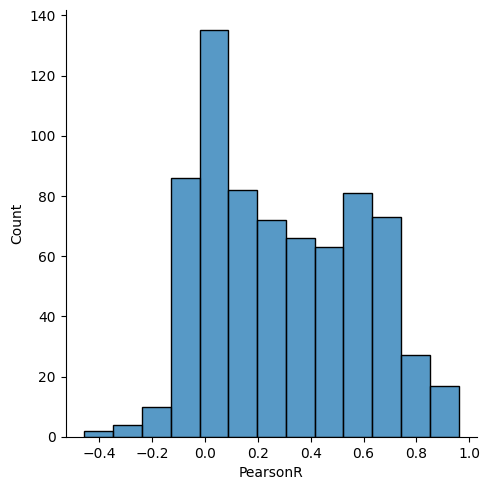

In [11]:
sns.displot(df['PearsonR'])
# pd.DataFrame(ResultList)

In [52]:
# rank_mean = TrainTpm.stack().groupby(TrainTpm.rank(method='first').stack().astype(int)).mean()
# TrainTpmQuantile = TrainTpm.rank(method='min').stack().astype(int).map(rank_mean).unstack()
# rank_mean = GtexTpm.stack().groupby(GtexTpm.rank(method='first').stack().astype(int)).mean()
# GtexTpmQuantile = GtexTpm.rank(method='min').stack().astype(int).map(rank_mean).unstack()

In [47]:
def plotCpgGtex(CPG, Model,  CpgsGeneDict, axes):
    Gene = CpgsGeneDict[CPG]
    QueryGene = pd.DataFrame()
    QueryGene['Gene'] = GtexTpm[Gene]
    QueryGene.index = GtexTpm.T.columns
    QueryGene.loc[:,"Group"] = QueryGene['Gene'].apply(lambda x: "High" if x > QueryGene['Gene'].median() else "Low")
    QueryGene.loc[:,"Meth"] =  GtexMeth[CPG].values
    Model.fit(TPMscaler.fit_transform(TrainTpm[Gene].fillna(0)), TrainMeth[CPG].fillna(0).values)
    predictedMeth = Model.predict(TPMscaler.fit_transform(GtexTpm[Gene].fillna(0)))
    QueryGene.loc[:,"Pred Meth"] =  predictedMeth
    sns.boxplot(pd.melt(QueryGene[['Group','Meth','Pred Meth']], id_vars='Group'), x='variable', y='value', hue='Group', ax=axes)
    plt.tight_layout()

In [48]:
models[df.loc['cg27539721']['Model']]

GradientBoostingRegressor()

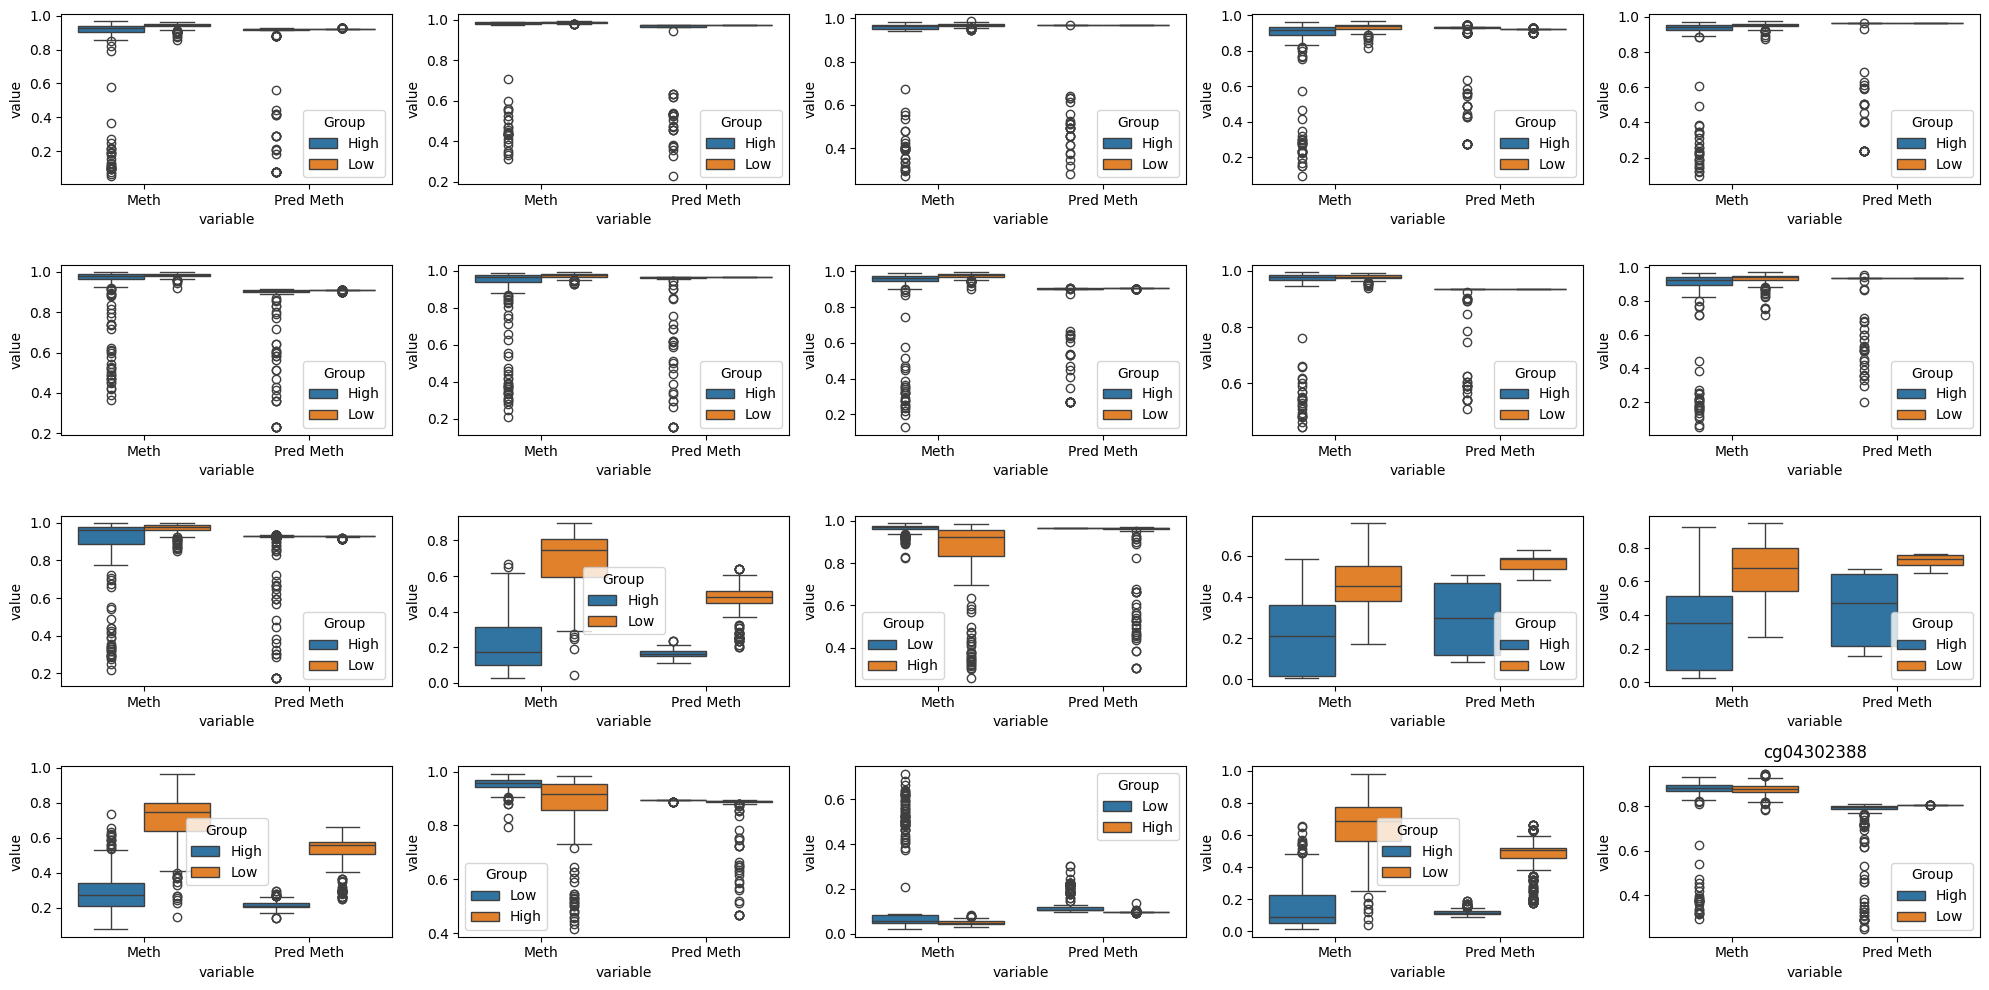

In [49]:
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
axes = list(axes.flatten())
i = 0
for cpgs in df[df['No.Genes'] == 1].sort_values(by='PearsonR',ascending=False).index[:20]:
    # print(cpgs)
    ax = plotCpgGtex(cpgs, models[df.loc['cg27539721']['Model']], CpgsGeneDict, axes[i])
    plt.title(f'{cpgs}')
    i += 1